# bigsimr tutorial
## Installation
### Julia installation
To install Julia on your machine, you can follow the instruction at Julia website at https://julialang.org/downloads/. Julia can also be installed in linux using the script below. It will create a folder named julia in the home folder and add necessary PATH to .bashrc file.

In [1]:
# ! mkdir ~/julia
# ! wget https://julialang-s3.julialang.org/bin/linux/x64/1.5/julia-1.5.3-linux-x86_64.tar.gz -O ~/julia/julia-1.5.3-linux-x86_64.tar.gz
# ! tar zxvf ~/julia/julia-1.5.3-linux-x86_64.tar.gz -C ~/julia
# ! echo "export PATH='$PATH:$HOME/julia/julia-1.5.3/bin'" >> ~/.bashrc

## bigsimr installation
Install bigsimr and julia packages from pip using these commands. julia package is used to communicate with Julia from python.

In [2]:
# ! pip install https://github.com/SchisslerGroup/python-bigsimr
# ! pip install julia


After that, setup function can be used to installed the necessary Julia packages for bigsimr.

In [3]:
# from bigsimr import setup
# setup()

## Simulation example
### Importing necessary dependencies
This line can be removed for better performance. However, it can lead to error in some system.
>jl = Julia(compiled_modules=False)

In [2]:
from julia.api import Julia

jl = Julia(compiled_modules=False)

from julia import Bigsimr, Distributions

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm, lognorm

In [6]:
df = pd.read_csv('airquality.csv')
df

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5
...,...,...,...,...,...,...
148,30.0,193.0,6.9,70,9,26
149,NaN,145.0,13.2,77,9,27
150,14.0,191.0,14.3,75,9,28
151,18.0,131.0,8.0,76,9,29


In [7]:
df = df[['Ozone', 'Temp']]
df = df.dropna()
df = df.reset_index(drop=True)
df

,Ozone,Temp
0,41.0,67
1,36.0,72
2,12.0,74
3,18.0,62
4,28.0,66
...,...,...
111,14.0,63
112,30.0,70
113,14.0,75
114,18.0,76


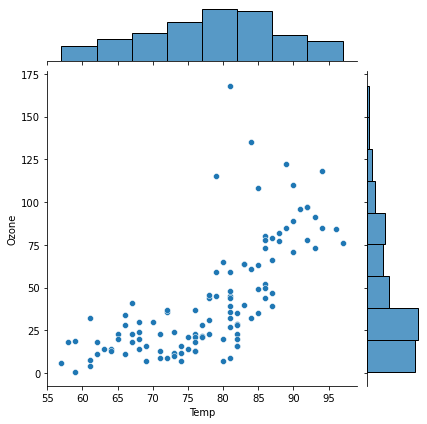

In [8]:

sns.jointplot(x=df['Temp'], y=df['Ozone'], kind='scatter', cmap="viridis")
plt.show()


In [9]:
rho = Bigsimr.cor_fast(df.values)
rho

array([[1.        , 0.69836034],
       [0.69836034, 1.        ]])

In [10]:
ozone = df['Ozone'].values
print('Ozone summary: logmean = {0:.2f}, logsd = {1:.2f}'.format(
    np.mean(np.log(ozone)), 
    np.std(np.log(ozone))
))

temp = df['Temp'].values
print('Temperature summary: mean = {0:.2f}, sd = {1:.2f}'.format(
    np.mean(temp), 
    np.std(temp)
))

Ozone summary: logmean = 3.42, logsd = 0.86
Temperature summary: mean = 77.87, sd = 9.44


In [11]:
margins = [
    Distributions.LogNormal(3.42, 0.86),
    Distributions.Normal(77.84, 9.44)
]

In [12]:
rv = Bigsimr.rvec(10000, rho, margins)

print('Correlation of simulated data without pearson matching:')
print(Bigsimr.cor_fast(rv))

[[1.         0.57976946]
 [0.57976946 1.        ]]


In [13]:
D = Bigsimr.MvDistribution(rho, margins, Bigsimr.Pearson)
D = Bigsimr.pearson_match(D)
rho_match = Bigsimr.cor_convert(Bigsimr.cor(D), Bigsimr.cortype(D), Bigsimr.Pearson)
rho_match = Bigsimr.cor_nearPD(rho_match)
rv = Bigsimr.rvec(10000, rho_match, Bigsimr.margins(D))

print('Correlation of simulated data with pearson matching:')
print(Bigsimr.cor_fast(rv))

[[1.         0.71118225]
 [0.71118225 1.        ]]


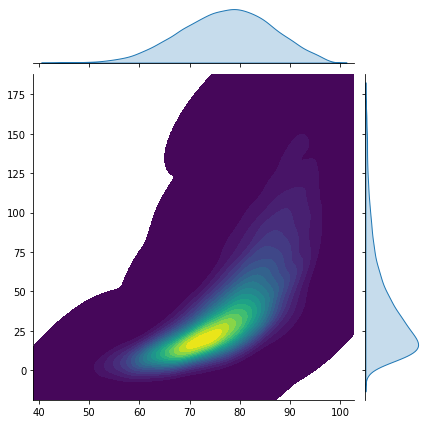

In [14]:
rv = rv[(rv[:,0]>0) & (rv[:,0]<ozone.max()) & (rv[:,1]>0) & (rv[:,1]<temp.max()), :]

sns.jointplot(x=rv[:,1], y=rv[:,0], kind='kde', cmap="viridis", fill=True, thresh=0, levels=20)
plt.show()

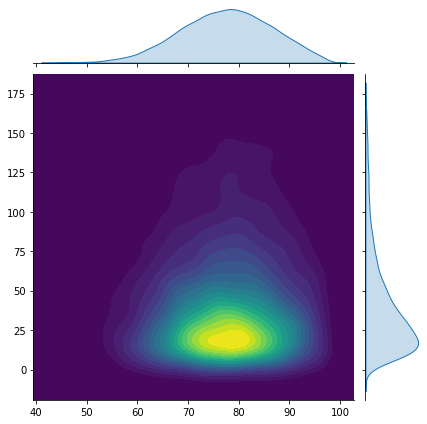

In [15]:
np.random.seed(1)
rv = np.stack([
    lognorm.rvs(size=10000, s=0.86, scale=np.exp(3.42)),
    norm.rvs(size=10000, loc=77.87, scale=9.44)
], 1)

rv = rv[(rv[:,0]>0) & (rv[:,0]<ozone.max()) & (rv[:,1]>0) & (rv[:,1]<temp.max()), :]

sns.jointplot(x=rv[:,1], y=rv[:,0], kind='kde', cmap="viridis", fill=True, thresh=0, levels=20)
plt.show()








